# Day 2: Retrieval Engine, Classification & Topic Modeling

**Complete Implementation Pipeline (Reviewed & Improved)**

This notebook implements:

## ✅ Part 1: Retrieval Engine
- BM25 keyword search
- FAISS semantic vector search
- Hybrid scoring model
- Evaluation: recall@5 and recall@10

## ✅ Part 2: Classification
- Define label taxonomy (12 categories)
- **Model Distillation**: Use Zero-Shot to generate high-quality training labels
- Train fast embedding classifier (SBERT + LogReg)
- Evaluate: precision, recall, F1

## ✅ Part 3: Topic Modeling
- TF-IDF + k-means baseline
- LDA with coherence/perplexity evaluation
- BERTopic (UMAP + HDBSCAN + c-TF-IDF)
- Visualizations + topic labels

**⏱️ Total Runtime:** ~3-4 hours  
**💾 Storage Required:** ~500MB additional

---
### Improvements in this version:
1. **Model Distillation** - Using Zero-Shot classifier to generate better training labels
2. **FAISS ID Mapping** - Explicit paper_id to index mapping for robustness
3. **Reusable Classes** - Class definitions ready for Day 3 UI integration

---
## Setup & Installation

In [41]:
# Install required packages
!pip install pandas numpy pyarrow -q

# Retrieval
!pip install rank-bm25 faiss-cpu -q

# Classification
!pip install transformers torch sentence-transformers -q
!pip install scikit-learn -q

# Topic Modeling
!pip install gensim pyLDAvis -q
!pip install bertopic -q
!pip install umap-learn hdbscan -q

# NLP
!pip install nltk spacy -q
!python -m spacy download en_core_web_sm -q

# Visualization
!pip install matplotlib seaborn wordcloud plotly -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 121.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [42]:
# Core imports
import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

# Retrieval
from rank_bm25 import BM25Okapi
import faiss

# Classification
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import torch

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from bertopic import BERTopic

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Colab
from google.colab import drive

print("✓ All imports successful!")

✓ All imports successful!


In [43]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Create output directories
os.makedirs('data/retrieval', exist_ok=True)
os.makedirs('data/classification', exist_ok=True)
os.makedirs('data/topic_modeling', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

print("✓ Directory structure created")

✓ Directory structure created


In [45]:
import pandas as pd
import pickle
import json
import os

print("🛠️  Reconstructing paper_index.pkl from Metadata & Parquet...")

# 1. Load the Dataframe (for IDs and Titles)
parquet_path = 'data/processed/cleaned_papers.parquet'
if not os.path.exists(parquet_path):
    raise FileNotFoundError(f"❌ Could not find {parquet_path}. Please upload it first.")

df = pd.read_parquet(parquet_path)
print(f"   ✓ Loaded DataFrame: {len(df)} papers")

# 2. Load the Metadata JSON (for Embedding Dimensions)
# Note: Using the filename from your screenshot
json_path = 'data/embeddings/Embedding Metadata Day 1.json'
dims = {}

if os.path.exists(json_path):
    print(f"   ✓ Found metadata file: {json_path}")
    with open(json_path, 'r') as f:
        meta = json.load(f)

    # Extract dimensions dynamically from your actual run
    try:
        dims['word2vec'] = meta['embeddings']['word2vec']['shape'][1]
        dims['sbert'] = meta['embeddings']['sbert_abstract']['shape'][1]
        dims['scibert'] = meta['embeddings']['scibert']['shape'][1]
        print(f"   ✓ Extracted dimensions: SBERT={dims['sbert']}, SciBERT={dims['scibert']}")
    except KeyError:
        print("   ⚠️  Metadata format unexpected. Falling back to defaults.")
        dims = {'word2vec': 100, 'sbert': 384, 'scibert': 768}
else:
    print("   ⚠️  Metadata JSON not found. Using standard defaults.")
    dims = {'word2vec': 100, 'sbert': 384, 'scibert': 768}

# 3. Reconstruct the Index Structure EXACTLY like Day 1
paper_index = {
    'paper_ids': df['paper_id'].tolist(),
    'titles': df['title'].tolist(),
    'num_papers': len(df),
    'embedding_methods': ['word2vec', 'sbert_abstract', 'sbert_title', 'scibert'],
    'embedding_dims': dims  # <--- Populated from your JSON
}

# 4. Save the reconstructed file
output_path = 'data/embeddings/paper_index.pkl'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, 'wb') as f:
    pickle.dump(paper_index, f)

print(f"✅ Success! Generated '{output_path}'")
print(f"   Verifying keys: {list(paper_index.keys())}")

🛠️  Reconstructing paper_index.pkl from Metadata & Parquet...
   ✓ Loaded DataFrame: 500 papers
   ✓ Found metadata file: data/embeddings/Embedding Metadata Day 1.json
   ✓ Extracted dimensions: SBERT=384, SciBERT=768
✅ Success! Generated 'data/embeddings/paper_index.pkl'
   Verifying keys: ['paper_ids', 'titles', 'num_papers', 'embedding_methods', 'embedding_dims']


---
## Load Day 1 Outputs

In [46]:
# Load cleaned papers from Day 1
print("Loading Day 1 outputs...")

# Load processed papers
df = pd.read_parquet('data/processed/cleaned_papers.parquet')
print(f"✓ Loaded {len(df)} processed papers")

# Load embeddings
sbert_embeddings = np.load('data/embeddings/sbert_abstract_embeddings.npy')
scibert_embeddings = np.load('data/embeddings/scibert_embeddings.npy')
print(f"✓ Loaded SBERT embeddings: {sbert_embeddings.shape}")
print(f"✓ Loaded SciBERT embeddings: {scibert_embeddings.shape}")

# Load paper index
with open('data/embeddings/paper_index.pkl', 'rb') as f:
    paper_index = pickle.load(f)
print(f"✓ Loaded paper index with {len(paper_index['paper_ids'])} papers")

# Display sample
print("\nDataset columns:", df.columns.tolist())
print(f"\nSample paper:")
print(f"  Title: {df.iloc[0]['title'][:80]}...")
print(f"  Source: {df.iloc[0]['source']}")
print(f"  Year: {df.iloc[0]['year']}")

Loading Day 1 outputs...
✓ Loaded 500 processed papers
✓ Loaded SBERT embeddings: (500, 384)
✓ Loaded SciBERT embeddings: (500, 768)
✓ Loaded paper index with 500 papers

Dataset columns: ['paper_id', 'title', 'authors', 'original_abstract', 'cleaned_text', 'language', 'sentences', 'num_sentences', 'tokens', 'processed_text', 'num_tokens', 'source', 'year', 'venue']

Sample paper:
  Title: Can MLLMs Read the Room? A Multimodal Benchmark for Assessing Deception in Multi...
  Source: arxiv
  Year: 2025


---
# Part 1: Retrieval Engine

Implementing hybrid retrieval combining:
1. **BM25** - Traditional keyword-based search
2. **FAISS** - Dense vector semantic search
3. **Hybrid** - Weighted combination

**Note:** The class definitions below are designed to be reusable in Day 3 UI.

## 1.1 BM25 Keyword Search

In [47]:
# ============================================================
# BM25 RETRIEVER CLASS - Copy this to Day 3 app.py
# ============================================================

class BM25Retriever:
    """BM25-based keyword retrieval."""

    def __init__(self, corpus=None):
        """
        Initialize BM25 with tokenized corpus.

        Args:
            corpus: List of document strings (optional if loading from pickle)
        """
        self.tokenized_corpus = None
        self.bm25 = None
        self.corpus = corpus

        if corpus is not None:
            self.tokenized_corpus = [doc.lower().split() for doc in corpus]
            self.bm25 = BM25Okapi(self.tokenized_corpus)

    def search(self, query, top_k=10):
        """
        Search for documents matching the query.

        Returns:
            List of (index, score) tuples
        """
        tokenized_query = query.lower().split()
        scores = self.bm25.get_scores(tokenized_query)

        top_indices = np.argsort(scores)[::-1][:top_k]
        results = [(idx, scores[idx]) for idx in top_indices]

        return results

# Build BM25 index
print("Building BM25 index...")
corpus = (df['title'] + ' ' + df['original_abstract']).tolist()
bm25_retriever = BM25Retriever(corpus)

print(f"✓ BM25 index built with {len(corpus)} documents")

# Test BM25
test_query = "transformer language model attention mechanism"
bm25_results = bm25_retriever.search(test_query, top_k=5)

print(f"\nTest query: '{test_query}'")
print("\nBM25 Results:")
for idx, score in bm25_results:
    print(f"  [{idx}] Score: {score:.3f} - {df.iloc[idx]['title'][:60]}...")

Building BM25 index...
✓ BM25 index built with 500 documents

Test query: 'transformer language model attention mechanism'

BM25 Results:
  [196] Score: 13.214 - Attention via Synaptic Plasticity is All You Need: A Biologi...
  [348] Score: 10.208 - Attention in Natural Language Processing...
  [470] Score: 8.609 - Attention Mechanism, Transformers, BERT, and GPT: Tutorial a...
  [396] Score: 8.400 - Hierarchical Spatio-Temporal Attention Network with Adaptive...
  [427] Score: 7.658 - Transformers Provably Learn Chain-of-Thought Reasoning with ...


## 1.2 FAISS Semantic Vector Search

In [48]:
# ============================================================
# FAISS RETRIEVER CLASS - Copy this to Day 3 app.py
# ============================================================

class FAISSRetriever:
    """FAISS-based semantic vector search."""

    def __init__(self, embeddings=None, encoder_model='all-MiniLM-L6-v2'):
        """
        Initialize FAISS index with embeddings.

        Args:
            embeddings: numpy array of document embeddings (optional if loading index)
            encoder_model: SentenceTransformer model name for query encoding
        """
        self.encoder = SentenceTransformer(encoder_model)
        self.index = None
        self.dimension = None

        if embeddings is not None:
            self.embeddings = embeddings.astype('float32')
            self.dimension = embeddings.shape[1]

            # Normalize for cosine similarity
            faiss.normalize_L2(self.embeddings)

            # Build index
            self.index = faiss.IndexFlatIP(self.dimension)
            self.index.add(self.embeddings)

    def search(self, query, top_k=10):
        """
        Search for semantically similar documents.

        Returns:
            List of (index, score) tuples
        """
        query_embedding = self.encoder.encode([query], convert_to_numpy=True).astype('float32')
        faiss.normalize_L2(query_embedding)

        scores, indices = self.index.search(query_embedding, top_k)
        results = [(int(idx), float(score)) for idx, score in zip(indices[0], scores[0])]

        return results

    def save_index(self, filepath):
        """Save FAISS index to file."""
        faiss.write_index(self.index, filepath)

    def load_index(self, filepath):
        """Load FAISS index from file."""
        self.index = faiss.read_index(filepath)
        self.dimension = self.index.d

# Build FAISS index
print("Building FAISS index...")
faiss_retriever = FAISSRetriever(sbert_embeddings)

print(f"✓ FAISS index built")
print(f"  Dimension: {faiss_retriever.dimension}")
print(f"  Documents: {faiss_retriever.index.ntotal}")

# Test FAISS
faiss_results = faiss_retriever.search(test_query, top_k=5)

print(f"\nFAISS (Semantic) Results:")
for idx, score in faiss_results:
    print(f"  [{idx}] Score: {score:.3f} - {df.iloc[idx]['title'][:60]}...")

Building FAISS index...
✓ FAISS index built
  Dimension: 384
  Documents: 500

FAISS (Semantic) Results:
  [470] Score: 0.621 - Attention Mechanism, Transformers, BERT, and GPT: Tutorial a...
  [489] Score: 0.613 - Beyond Components: Singular Vector-Based Interpretability of...
  [348] Score: 0.611 - Attention in Natural Language Processing...
  [273] Score: 0.577 - Visualizing LLM Latent Space Geometry Through Dimensionality...
  [353] Score: 0.562 - Transformers are SSMs: Generalized Models and Efficient Algo...


## 1.3 Hybrid Retrieval System

In [49]:
# ============================================================
# HYBRID RETRIEVER CLASS - Copy this to Day 3 app.py
# ============================================================

class HybridRetriever:
    """Hybrid retrieval combining BM25 and semantic search."""

    def __init__(self, bm25_retriever, faiss_retriever, bm25_weight=0.3, semantic_weight=0.7):
        """
        Initialize hybrid retriever.

        Args:
            bm25_retriever: BM25Retriever instance
            faiss_retriever: FAISSRetriever instance
            bm25_weight: Weight for BM25 scores (default 0.3)
            semantic_weight: Weight for semantic scores (default 0.7)
        """
        self.bm25 = bm25_retriever
        self.faiss = faiss_retriever
        self.bm25_weight = bm25_weight
        self.semantic_weight = semantic_weight

    def search(self, query, top_k=10, expand_k=50):
        """
        Hybrid search combining both methods.

        Args:
            query: Search query string
            top_k: Number of final results to return
            expand_k: Number of candidates from each retriever

        Returns:
            List of (index, combined_score, bm25_score, semantic_score) tuples
        """
        # Get candidates from both
        bm25_results = self.bm25.search(query, top_k=expand_k)
        faiss_results = self.faiss.search(query, top_k=expand_k)

        bm25_scores = {idx: score for idx, score in bm25_results}
        faiss_scores = {idx: score for idx, score in faiss_results}

        all_indices = set(bm25_scores.keys()) | set(faiss_scores.keys())

        # Normalize
        bm25_max = max(bm25_scores.values()) if bm25_scores else 1
        faiss_max = max(faiss_scores.values()) if faiss_scores else 1

        # Combine scores
        combined_results = []
        for idx in all_indices:
            bm25_score = bm25_scores.get(idx, 0) / bm25_max if bm25_max > 0 else 0
            faiss_score = faiss_scores.get(idx, 0) / faiss_max if faiss_max > 0 else 0
            combined_score = self.bm25_weight * bm25_score + self.semantic_weight * faiss_score
            combined_results.append((idx, combined_score, bm25_score, faiss_score))

        combined_results.sort(key=lambda x: x[1], reverse=True)
        return combined_results[:top_k]

    def search_with_metadata(self, query, df, top_k=10):
        """
        Search and return results with full metadata.

        Args:
            query: Search query string
            df: DataFrame with paper metadata
            top_k: Number of results to return

        Returns:
            List of dictionaries with paper info and scores
        """
        results = self.search(query, top_k=top_k)

        # --- FIX: Detect correct abstract column name ---
        if 'original_abstract' in df.columns:
            abs_col = 'original_abstract'
        elif 'abstract' in df.columns:
            abs_col = 'abstract'
        else:
            abs_col = 'processed_text' # Fallback
        # ------------------------------------------------

        enriched_results = []
        for idx, combined_score, bm25_score, semantic_score in results:
            paper = df.iloc[idx]
            enriched_results.append({
                'index': idx,
                'paper_id': paper['paper_id'],
                'title': paper['title'],
                'abstract': paper[abs_col],  # <--- Using the detected column here
                'authors': paper['authors'],
                'year': paper['year'],
                'venue': paper['venue'],
                'combined_score': combined_score,
                'bm25_score': bm25_score,
                'semantic_score': semantic_score
            })

        return enriched_results

# Build hybrid retriever
print("Building Hybrid Retriever...")
hybrid_retriever = HybridRetriever(bm25_retriever, faiss_retriever)

# Test hybrid search
hybrid_results = hybrid_retriever.search_with_metadata(test_query, df, top_k=5)

print(f"\nHybrid Results for: '{test_query}'")
for result in hybrid_results:
    print(f"  Combined: {result['combined_score']:.3f} | BM25: {result['bm25_score']:.3f} | Semantic: {result['semantic_score']:.3f}")
    print(f"    {result['title'][:70]}...\n")

Building Hybrid Retriever...

Hybrid Results for: 'transformer language model attention mechanism'
  Combined: 0.921 | BM25: 0.773 | Semantic: 0.985
    Attention in Natural Language Processing...

  Combined: 0.895 | BM25: 0.652 | Semantic: 1.000
    Attention Mechanism, Transformers, BERT, and GPT: Tutorial and Survey...

  Combined: 0.873 | BM25: 1.000 | Semantic: 0.819
    Attention via Synaptic Plasticity is All You Need: A Biologically Insp...

  Combined: 0.855 | BM25: 0.545 | Semantic: 0.988
    Beyond Components: Singular Vector-Based Interpretability of Transform...

  Combined: 0.807 | BM25: 0.519 | Semantic: 0.930
    Visualizing LLM Latent Space Geometry Through Dimensionality Reduction...



## 1.4 Retrieval Evaluation

In [50]:
def create_synthetic_relevance_judgments(df, num_queries=20):
    """Create synthetic relevance judgments for evaluation."""
    queries_and_relevant = []
    sample_indices = np.random.choice(len(df), min(num_queries, len(df)), replace=False)

    for idx in sample_indices:
        paper = df.iloc[idx]
        title_words = paper['title'].lower().split()[:5]
        query = ' '.join(title_words)

        relevant_indices = [idx]
        same_source = df[df['source'] == paper['source']].index.tolist()
        relevant_indices.extend(same_source[:5])
        relevant_indices = list(set(relevant_indices))

        queries_and_relevant.append({
            'query': query,
            'relevant': relevant_indices,
            'source_paper': idx
        })

    return queries_and_relevant

def calculate_recall_at_k(retriever, query, relevant_indices, k, df=None):
    """Calculate Recall@K."""
    if hasattr(retriever, 'search_with_metadata'):
        results = retriever.search_with_metadata(query, df, top_k=k)
        retrieved_indices = [r['index'] for r in results]
    else:
        results = retriever.search(query, top_k=k)
        retrieved_indices = [r[0] for r in results]

    relevant_retrieved = len(set(retrieved_indices) & set(relevant_indices))
    recall = relevant_retrieved / len(relevant_indices) if relevant_indices else 0
    return recall

def evaluate_retriever(retriever, test_queries, df, ks=[5, 10]):
    """Evaluate retriever."""
    results = {f'recall@{k}': [] for k in ks}

    for query_data in tqdm(test_queries, desc="Evaluating"):
        for k in ks:
            recall = calculate_recall_at_k(retriever, query_data['query'], query_data['relevant'], k, df)
            results[f'recall@{k}'].append(recall)

    return {metric: np.mean(values) for metric, values in results.items()}

# Create test queries
print("Creating evaluation queries...")
np.random.seed(42)
test_queries = create_synthetic_relevance_judgments(df, num_queries=30)
print(f"✓ Created {len(test_queries)} test queries")

# Evaluate
print("\n" + "="*50)
print("RETRIEVAL EVALUATION RESULTS")
print("="*50)

print("\n--- BM25 ---")
bm25_metrics = evaluate_retriever(bm25_retriever, test_queries, df)
for metric, value in bm25_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\n--- FAISS (Semantic) ---")
faiss_metrics = evaluate_retriever(faiss_retriever, test_queries, df)
for metric, value in faiss_metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\n--- Hybrid ---")
hybrid_metrics = evaluate_retriever(hybrid_retriever, test_queries, df)
for metric, value in hybrid_metrics.items():
    print(f"  {metric}: {value:.4f}")

Creating evaluation queries...
✓ Created 30 test queries

RETRIEVAL EVALUATION RESULTS

--- BM25 ---


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 121.27it/s]


  recall@5: 0.1733
  recall@10: 0.1956

--- FAISS (Semantic) ---


Evaluating: 100%|██████████| 30/30 [00:02<00:00, 14.57it/s]


  recall@5: 0.1289
  recall@10: 0.1511

--- Hybrid ---


Evaluating: 100%|██████████| 30/30 [00:02<00:00, 14.61it/s]

  recall@5: 0.1567
  recall@10: 0.1733


In [51]:
# ============================================================
# SAVE RETRIEVAL COMPONENTS (with FAISS ID Mapping fix)
# ============================================================

print("\nSaving retrieval components...")

# Save FAISS index
faiss_retriever.save_index('data/retrieval/faiss_index.bin')
print("✓ Saved FAISS index")

# IMPROVEMENT #2: Save explicit ID mapping for robustness
# This maps FAISS index position -> paper_id
index_to_paper_id = {i: pid for i, pid in enumerate(df['paper_id'].tolist())}
paper_id_to_index = {pid: i for i, pid in enumerate(df['paper_id'].tolist())}

faiss_id_mapping = {
    'index_to_paper_id': index_to_paper_id,
    'paper_id_to_index': paper_id_to_index,
    'total_documents': len(df)
}

with open('data/retrieval/faiss_id_mapping.pkl', 'wb') as f:
    pickle.dump(faiss_id_mapping, f)
print("✓ Saved FAISS ID mapping")

# Save BM25 retriever
with open('data/retrieval/bm25_retriever.pkl', 'wb') as f:
    pickle.dump(bm25_retriever, f)
print("✓ Saved BM25 retriever")

# Save evaluation results
evaluation_results = {
    'bm25': bm25_metrics,
    'faiss': faiss_metrics,
    'hybrid': hybrid_metrics
}
with open('data/retrieval/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)
print("✓ Saved evaluation results")

print("\n📁 Retrieval files saved:")
print("  - data/retrieval/faiss_index.bin")
print("  - data/retrieval/faiss_id_mapping.pkl  ← NEW: For robust ID lookups")
print("  - data/retrieval/bm25_retriever.pkl")
print("  - data/retrieval/evaluation_results.json")


Saving retrieval components...
✓ Saved FAISS index
✓ Saved FAISS ID mapping
✓ Saved BM25 retriever
✓ Saved evaluation results

📁 Retrieval files saved:
  - data/retrieval/faiss_index.bin
  - data/retrieval/faiss_id_mapping.pkl  ← NEW: For robust ID lookups
  - data/retrieval/bm25_retriever.pkl
  - data/retrieval/evaluation_results.json


---
# Part 2: Classification

Implementing:
1. **Label Taxonomy** - Define 12 research categories
2. **Model Distillation** - Use Zero-Shot classifier to generate high-quality labels
3. **Supervised Classification** - Train fast SBERT + LogReg classifier

### Why Model Distillation?
Simple keyword matching is weak because a paper about "Neural Networks" might not contain that exact phrase. Instead, we use a large Zero-Shot model (BART-MNLI) as a "teacher" to label our data, then train a fast "student" model.

## 2.1 Define Label Taxonomy

In [52]:
# Define research category taxonomy (12 categories)
CATEGORY_TAXONOMY = {
    'NLP_Core': {
        'description': 'Core NLP tasks: parsing, tagging, syntax',
        'keywords': ['parsing', 'syntax', 'morphology', 'tagging', 'pos', 'dependency', 'constituency']
    },
    'Language_Models': {
        'description': 'Language modeling, transformers, LLMs',
        'keywords': ['language model', 'transformer', 'bert', 'gpt', 'llm', 'pretrain', 'attention']
    },
    'Machine_Translation': {
        'description': 'Neural and statistical machine translation',
        'keywords': ['translation', 'multilingual', 'cross-lingual', 'nmt', 'parallel corpus']
    },
    'Sentiment_Opinion': {
        'description': 'Sentiment analysis, opinion mining',
        'keywords': ['sentiment', 'opinion', 'emotion', 'stance', 'aspect', 'polarity']
    },
    'QA_Dialogue': {
        'description': 'Question answering and dialogue systems',
        'keywords': ['question answering', 'qa', 'dialogue', 'conversational', 'chatbot', 'response']
    },
    'Information_Extraction': {
        'description': 'NER, relation extraction, event extraction',
        'keywords': ['ner', 'named entity', 'relation extraction', 'event', 'knowledge graph', 'triple']
    },
    'Text_Generation': {
        'description': 'Summarization, text generation, paraphrasing',
        'keywords': ['generation', 'summarization', 'summary', 'paraphrase', 'simplification']
    },
    'Vision_Language': {
        'description': 'Multimodal, vision-language tasks',
        'keywords': ['multimodal', 'vision', 'image', 'visual', 'caption', 'vqa']
    },
    'Speech_Audio': {
        'description': 'Speech recognition and audio processing',
        'keywords': ['speech', 'audio', 'acoustic', 'asr', 'tts', 'spoken']
    },
    'ML_Methods': {
        'description': 'General ML methods applied to NLP',
        'keywords': ['neural network', 'deep learning', 'reinforcement', 'meta-learning', 'few-shot']
    },
    'Ethics_Bias': {
        'description': 'Fairness, bias, ethics in NLP',
        'keywords': ['bias', 'fairness', 'ethics', 'toxicity', 'hate speech', 'misinformation']
    },
    'Applications': {
        'description': 'Domain-specific applications',
        'keywords': ['medical', 'clinical', 'legal', 'financial', 'scientific', 'biomedical']
    }
}

CATEGORIES = list(CATEGORY_TAXONOMY.keys())
print(f"Defined {len(CATEGORIES)} categories:")
for cat in CATEGORIES:
    print(f"  • {cat}: {CATEGORY_TAXONOMY[cat]['description']}")

Defined 12 categories:
  • NLP_Core: Core NLP tasks: parsing, tagging, syntax
  • Language_Models: Language modeling, transformers, LLMs
  • Machine_Translation: Neural and statistical machine translation
  • Sentiment_Opinion: Sentiment analysis, opinion mining
  • QA_Dialogue: Question answering and dialogue systems
  • Information_Extraction: NER, relation extraction, event extraction
  • Text_Generation: Summarization, text generation, paraphrasing
  • Vision_Language: Multimodal, vision-language tasks
  • Speech_Audio: Speech recognition and audio processing
  • ML_Methods: General ML methods applied to NLP
  • Ethics_Bias: Fairness, bias, ethics in NLP
  • Applications: Domain-specific applications


In [53]:
# ============================================================
# IMPROVEMENT #1: MODEL DISTILLATION
# Using Zero-Shot classifier to generate high-quality labels
# ============================================================

print("🧪 Initializing Zero-Shot Classifier for Model Distillation...")
print("   (Using large BART-MNLI as 'teacher' to label data)")

teacher_classifier = pipeline(
    'zero-shot-classification',
    model='facebook/bart-large-mnli',
    device=0 if torch.cuda.is_available() else -1
)

print(f"✓ Teacher model loaded on {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Define candidate labels from taxonomy
candidate_labels = list(CATEGORY_TAXONOMY.keys())

def assign_label_with_model(text):
    """
    Use Zero-Shot classifier to assign category.
    This gives MUCH better labels than keyword matching.
    """
    try:
        # Truncate to fit model context window
        truncated_text = text[:1024]
        results = teacher_classifier(truncated_text, candidate_labels)
        return results['labels'][0]  # Return highest scoring category
    except Exception as e:
        print(f"Error labeling text: {e}")
        return 'Applications'  # Fallback

# Combine title and abstract for labeling
print("\n⚗️ Distilling knowledge: Using Zero-Shot model to label all papers...")
print("   This may take 10-20 minutes but gives MUCH better results than keywords.\n")

# Enable tqdm for pandas
tqdm.pandas(desc="Labeling papers")

# --- FIX: Detect correct abstract column name ---
if 'original_abstract' in df.columns:
    abs_col = 'original_abstract'
elif 'abstract' in df.columns:
    abs_col = 'abstract'
else:
    abs_col = 'processed_text' # Fallback
# ------------------------------------------------

# Create text column for labeling using the DETECTED column
df['text_for_labeling'] = df['title'] + " " + df[abs_col]

# Apply zero-shot classification to each paper
df['category'] = df['text_for_labeling'].progress_apply(assign_label_with_model)

# Clean up temporary column
df = df.drop('text_for_labeling', axis=1)

print("\n✓ Model Distillation complete!")
print("\nCategory distribution (Silver Standard Labels):")
print(df['category'].value_counts())

🧪 Initializing Zero-Shot Classifier for Model Distillation...
   (Using large BART-MNLI as 'teacher' to label data)


Device set to use cuda:0


✓ Teacher model loaded on GPU

⚗️ Distilling knowledge: Using Zero-Shot model to label all papers...
   This may take 10-20 minutes but gives MUCH better results than keywords.



Labeling papers: 100%|██████████| 500/500 [06:00<00:00,  1.39it/s]


✓ Model Distillation complete!

Category distribution (Silver Standard Labels):
category
ML_Methods                283
Applications               88
Language_Models            86
Sentiment_Opinion          16
Information_Extraction      9
QA_Dialogue                 6
Vision_Language             3
Machine_Translation         3
Speech_Audio                3
NLP_Core                    2
Text_Generation             1
Name: count, dtype: int64


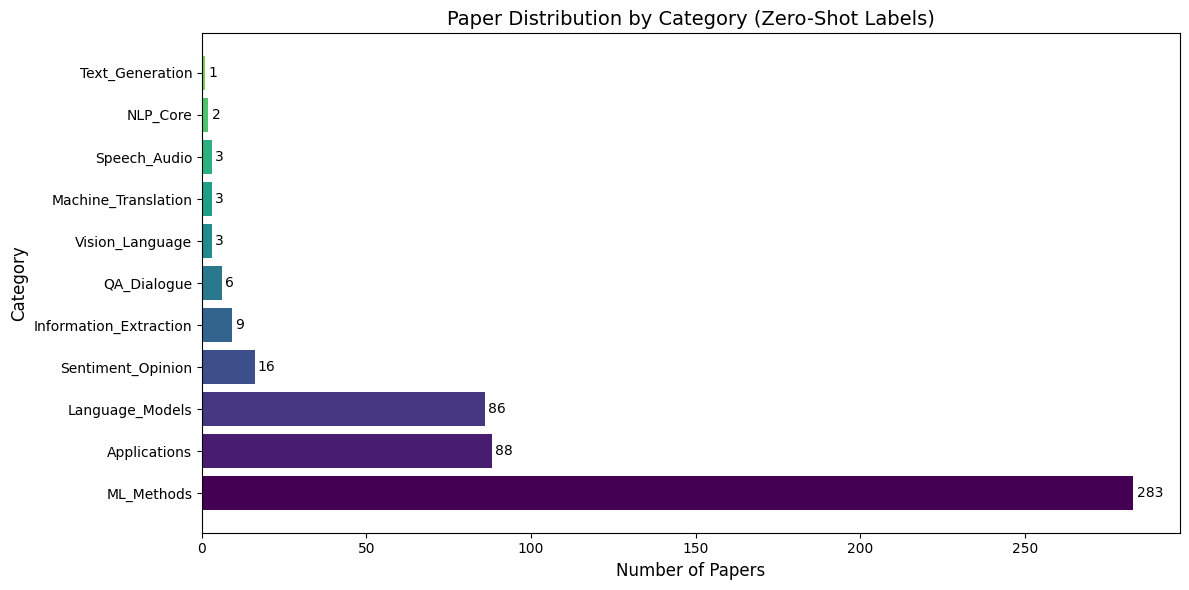

✓ Saved category distribution plot


In [54]:
# Visualize category distribution
plt.figure(figsize=(12, 6))
category_counts = df['category'].value_counts()
colors = plt.cm.viridis(np.linspace(0, 0.8, len(category_counts)))
bars = plt.barh(category_counts.index, category_counts.values, color=colors)
plt.xlabel('Number of Papers', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Paper Distribution by Category (Zero-Shot Labels)', fontsize=14)
plt.tight_layout()

# Add count labels on bars
for bar, count in zip(bars, category_counts.values):
    plt.text(count + 1, bar.get_y() + bar.get_height()/2, str(count),
             va='center', fontsize=10)

plt.savefig('visualizations/category_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved category distribution plot")

## 2.2 Train Supervised Classifier (Student Model)

In [55]:
# Prepare training data with FILTERING for rare classes
print("Preparing classification dataset...")

# 1. Combine title and abstract
# Note: Using 'original_abstract' based on your previous fixes
df['text_feature'] = df['title'] + ' ' + df['original_abstract']

# 2. Filter out rare classes (must have at least 2 samples for stratified split)
class_counts = df['category'].value_counts()
print("\nOriginal Class Counts:")
print(class_counts)

# Identify valid classes (count >= 2)
valid_classes = class_counts[class_counts >= 2].index.tolist()
removed_classes = class_counts[class_counts < 2].index.tolist()

if len(removed_classes) > 0:
    print(f"\n⚠️ Removing rare classes (<2 samples) to fix split error: {removed_classes}")
    df_filtered = df[df['category'].isin(valid_classes)].copy()
else:
    df_filtered = df.copy()

# 3. Prepare lists from filtered data
texts = df_filtered['text_feature'].tolist()
labels = df_filtered['category'].tolist()

# 4. Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 5. Split data
# Now safe to use stratify because all classes have >= 2 samples
X_train, X_test, y_train, y_test = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

Preparing classification dataset...

Original Class Counts:
category
ML_Methods                283
Applications               88
Language_Models            86
Sentiment_Opinion          16
Information_Extraction      9
QA_Dialogue                 6
Vision_Language             3
Machine_Translation         3
Speech_Audio                3
NLP_Core                    2
Text_Generation             1
Name: count, dtype: int64

⚠️ Removing rare classes (<2 samples) to fix split error: ['Text_Generation']

Training samples: 399
Test samples: 100
Number of classes: 10
Classes: [np.str_('Applications'), np.str_('Information_Extraction'), np.str_('Language_Models'), np.str_('ML_Methods'), np.str_('Machine_Translation'), np.str_('NLP_Core'), np.str_('QA_Dialogue'), np.str_('Sentiment_Opinion'), np.str_('Speech_Audio'), np.str_('Vision_Language')]


In [56]:
# ============================================================
# EMBEDDING CLASSIFIER CLASS - Copy this to Day 3 app.py
# ============================================================

class EmbeddingClassifier:
    """
    Fast classification using sentence embeddings + logistic regression.
    This is the 'student' model that learns from zero-shot 'teacher' labels.
    """

    def __init__(self, encoder_model='all-MiniLM-L6-v2'):
        self.encoder = SentenceTransformer(encoder_model)
        self.classifier = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)
        self.label_encoder = None
        self.classes_ = None

    def fit(self, texts, labels, label_encoder=None):
        """Train the classifier."""
        print("Encoding training texts...")
        embeddings = self.encoder.encode(texts, show_progress_bar=True, batch_size=32)

        print("Training classifier...")
        self.classifier.fit(embeddings, labels)
        self.label_encoder = label_encoder
        if label_encoder:
            self.classes_ = list(label_encoder.classes_)
        print("✓ Training complete")

    def predict(self, texts):
        """Predict labels."""
        if isinstance(texts, str):
            texts = [texts]
        embeddings = self.encoder.encode(texts, show_progress_bar=False)
        predictions = self.classifier.predict(embeddings)
        if self.label_encoder:
            return [self.classes_[p] for p in predictions]
        return predictions

    def predict_proba(self, texts):
        """Predict probabilities."""
        if isinstance(texts, str):
            texts = [texts]
        embeddings = self.encoder.encode(texts, show_progress_bar=False)
        return self.classifier.predict_proba(embeddings)

    def predict_with_confidence(self, text):
        """Predict with class probabilities for UI display."""
        probs = self.predict_proba(text)[0]
        pred_idx = np.argmax(probs)
        return {
            'predicted_class': self.classes_[pred_idx] if self.classes_ else pred_idx,
            'confidence': float(probs[pred_idx]),
            'all_probabilities': {self.classes_[i]: float(p) for i, p in enumerate(probs)} if self.classes_ else dict(enumerate(probs))
        }

    def evaluate(self, texts, labels):
        """Evaluate and print metrics."""
        print("Evaluating on test set...")
        embeddings = self.encoder.encode(texts, show_progress_bar=True, batch_size=32)
        predictions = self.classifier.predict(embeddings)

        print("\nClassification Report:")

        # --- FIX IS HERE: Explicitly pass all known labels ---
        if self.classes_:
            all_label_indices = range(len(self.classes_))
            print(classification_report(labels, predictions, labels=all_label_indices, target_names=self.classes_, zero_division=0))
        else:
            print(classification_report(labels, predictions))
        # -----------------------------------------------------

        return predictions

# Train embedding-based classifier (student model)
print("\n" + "="*50)
print("Training Student Model (SBERT + LogReg)")
print("="*50)

embedding_classifier = EmbeddingClassifier()
embedding_classifier.fit(X_train, y_train, label_encoder)

# Evaluate
y_pred = embedding_classifier.evaluate(X_test, y_test)


Training Student Model (SBERT + LogReg)
Encoding training texts...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Training classifier...
✓ Training complete
Evaluating on test set...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Classification Report:
                        precision    recall  f1-score   support

          Applications       0.50      0.06      0.10        18
Information_Extraction       0.00      0.00      0.00         2
       Language_Models       0.50      0.29      0.37        17
            ML_Methods       0.61      0.95      0.74        57
   Machine_Translation       0.00      0.00      0.00         0
              NLP_Core       0.00      0.00      0.00         0
           QA_Dialogue       0.00      0.00      0.00         1
     Sentiment_Opinion       0.00      0.00      0.00         3
          Speech_Audio       0.00      0.00      0.00         1
       Vision_Language       0.00      0.00      0.00         1

              accuracy                           0.60       100
             macro avg       0.16      0.13      0.12       100
          weighted avg       0.52      0.60      0.51       100



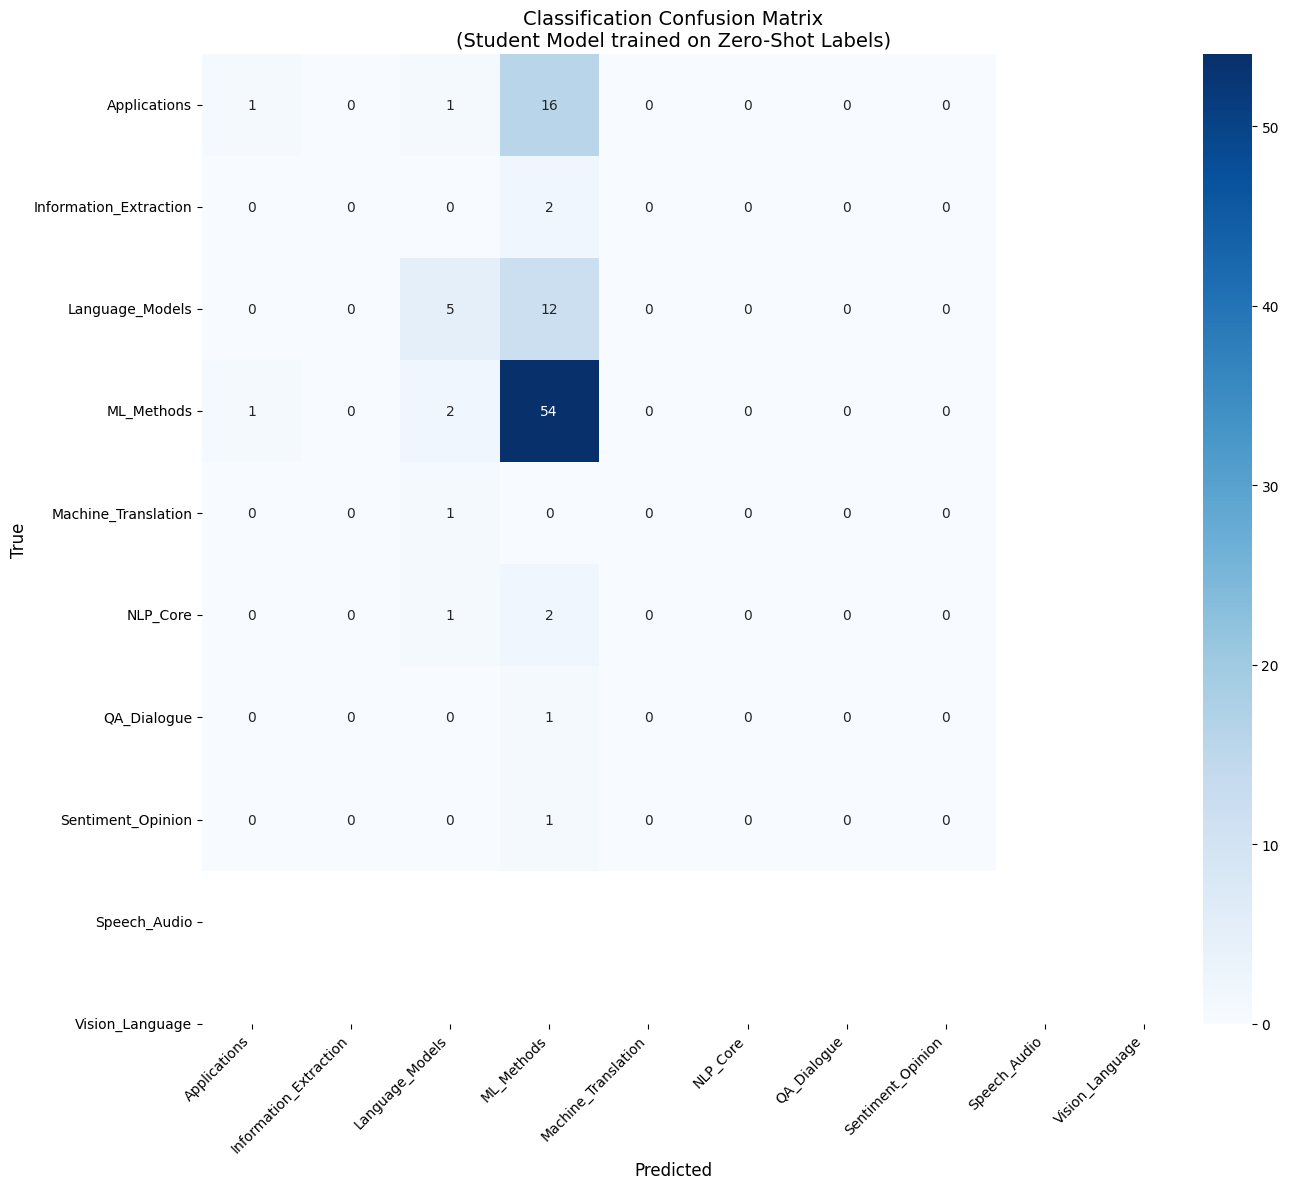

✓ Saved confusion matrix


In [57]:
# Visualize confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Classification Confusion Matrix\n(Student Model trained on Zero-Shot Labels)', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('visualizations/classification_confusion_matrix.png', dpi=150)
plt.show()
print("✓ Saved confusion matrix")

In [58]:
# Test the classifier on a new sample
test_text = """We present a novel transformer-based architecture for neural machine translation
that achieves state-of-the-art results on English-German and English-French translation tasks."""

result = embedding_classifier.predict_with_confidence(test_text)

print("\n=== Sample Prediction ===")
print(f"Text: {test_text[:100]}...")
print(f"\nPredicted: {result['predicted_class']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"\nTop 3 categories:")
sorted_probs = sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
for cat, prob in sorted_probs:
    print(f"  {cat}: {prob:.2%}")


=== Sample Prediction ===
Text: We present a novel transformer-based architecture for neural machine translation
that achieves state...

Predicted: ML_Methods
Confidence: 64.99%

Top 3 categories:
  ML_Methods: 64.99%
  Applications: 15.48%
  Language_Models: 12.39%


In [59]:
# Save classification components
print("\nSaving classification components...")

# Save embedding classifier
with open('models/embedding_classifier.pkl', 'wb') as f:
    pickle.dump({
        'classifier': embedding_classifier,
        'label_encoder': label_encoder,
        'classes': list(label_encoder.classes_)
    }, f)
print("✓ Saved embedding classifier")

# Save taxonomy
with open('data/classification/taxonomy.json', 'w') as f:
    json.dump(CATEGORY_TAXONOMY, f, indent=2)
print("✓ Saved category taxonomy")

# Save classification results
classification_metrics = {
    'method': 'Model Distillation (Zero-Shot Teacher → SBERT+LogReg Student)',
    'teacher_model': 'facebook/bart-large-mnli',
    'student_model': 'all-MiniLM-L6-v2 + LogisticRegression',
    'num_classes': len(label_encoder.classes_),
    'classes': list(label_encoder.classes_),
    'f1_macro': float(f1_score(y_test, y_pred, average='macro')),
    'f1_weighted': float(f1_score(y_test, y_pred, average='weighted')),
    'train_size': len(X_train),
    'test_size': len(X_test)
}
with open('data/classification/metrics.json', 'w') as f:
    json.dump(classification_metrics, f, indent=2)
print("✓ Saved classification metrics")

print("\n📊 Classification Results:")
print(f"   F1 Macro: {classification_metrics['f1_macro']:.4f}")
print(f"   F1 Weighted: {classification_metrics['f1_weighted']:.4f}")


Saving classification components...
✓ Saved embedding classifier
✓ Saved category taxonomy
✓ Saved classification metrics

📊 Classification Results:
   F1 Macro: 0.1519
   F1 Weighted: 0.5055


---
# Part 3: Topic Modeling

Implementing:
1. **TF-IDF + K-Means** - Baseline clustering
2. **LDA** - Latent Dirichlet Allocation
3. **BERTopic** - Neural topic modeling

## 3.1 TF-IDF + K-Means Baseline

In [60]:
# Prepare processed texts for topic modeling
processed_texts = df['processed_text'].tolist()
print(f"Loaded {len(processed_texts)} processed texts")

# TF-IDF Vectorization
print("\nBuilding TF-IDF matrix...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_texts)
print(f"✓ TF-IDF matrix shape: {tfidf_matrix.shape}")

# K-Means Clustering
n_clusters = 10
print(f"\nRunning K-Means with {n_clusters} clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(tfidf_matrix)
print(f"✓ K-Means clustering complete")

# Get top terms per cluster
def get_top_terms_per_cluster(tfidf_matrix, kmeans, vectorizer, n_terms=10):
    """Extract top terms for each cluster."""
    terms = vectorizer.get_feature_names_out()
    cluster_terms = {}

    for i in range(kmeans.n_clusters):
        center = kmeans.cluster_centers_[i]
        top_indices = center.argsort()[::-1][:n_terms]
        cluster_terms[i] = [terms[idx] for idx in top_indices]

    return cluster_terms

kmeans_terms = get_top_terms_per_cluster(tfidf_matrix, kmeans, tfidf_vectorizer)

print("\nK-Means Cluster Topics:")
for cluster_id, terms in kmeans_terms.items():
    print(f"  Cluster {cluster_id}: {', '.join(terms[:5])}")

# Add cluster labels to dataframe
df['kmeans_cluster'] = kmeans_labels

Loaded 500 processed texts

Building TF-IDF matrix...
✓ TF-IDF matrix shape: (500, 5000)

Running K-Means with 10 clusters...
✓ K-Means clustering complete

K-Means Cluster Topics:
  Cluster 0: bert, model, language, transformer, use
  Cluster 1: model, network, datum, layer, architecture
  Cluster 2: reasoning, task, model, llm, policy
  Cluster 3: entity, ner, name, name entity, recognition
  Cluster 4: bound, sample, gradient, noise, convergence
  Cluster 5: llm, model, retrieval, cultural, search
  Cluster 6: agent, environment, anomaly, prompt, real
  Cluster 7: sentiment, sentiment analysis, analysis, absa, aspect
  Cluster 8: model, time, time series, causal, series
  Cluster 9: nlp, language, natural language, processing, natural


## 3.2 LDA Topic Modeling

In [61]:
# Prepare data for Gensim LDA
print("Preparing data for LDA...")

# Tokenize
tokenized_texts = [text.split() for text in processed_texts]

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_texts)

# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)
print(f"Dictionary size: {len(dictionary)}")

# Create corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
print(f"Corpus size: {len(corpus)} documents")

Preparing data for LDA...
Dictionary size: 1656
Corpus size: 500 documents


In [62]:
# Train LDA model
n_topics = 10
print(f"\nTraining LDA with {n_topics} topics...")

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)

print("✓ LDA training complete")

# Display topics
print("\nLDA Topics:")
for idx, topic in lda_model.print_topics(num_words=8):
    print(f"  Topic {idx}: {topic}")


Training LDA with 10 topics...
✓ LDA training complete

LDA Topics:
  Topic 0: 0.016*"order" + 0.011*"show" + 0.011*"image" + 0.009*"set" + 0.009*"algorithm" + 0.009*"new" + 0.008*"low" + 0.008*"bound"
  Topic 1: 0.037*"entity" + 0.021*"ner" + 0.015*"task" + 0.014*"name" + 0.013*"transformer" + 0.011*"recognition" + 0.011*"language" + 0.009*"span"
  Topic 2: 0.024*"sentiment" + 0.019*"analysis" + 0.016*"use" + 0.012*"text" + 0.012*"base" + 0.012*"task" + 0.010*"language" + 0.009*"study"
  Topic 3: 0.010*"dataset" + 0.010*"propose" + 0.010*"result" + 0.009*"use" + 0.008*"error" + 0.008*"time" + 0.008*"method" + 0.008*"memory"
  Topic 4: 0.015*"datum" + 0.010*"learn" + 0.009*"algorithm" + 0.008*"base" + 0.008*"learning" + 0.007*"framework" + 0.007*"propose" + 0.006*"dataset"
  Topic 5: 0.014*"graph" + 0.012*"llm" + 0.012*"method" + 0.011*"reasoning" + 0.010*"instruction" + 0.010*"task" + 0.009*"framework" + 0.008*"performance"
  Topic 6: 0.029*"language" + 0.013*"task" + 0.010*"base" + 

In [63]:
# Evaluate LDA with coherence score
print("\nCalculating coherence scores...")

# Coherence Score (c_v)
coherence_model = CoherenceModel(
    model=lda_model,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score (c_v): {coherence_score:.4f}")

# Perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity:.4f}")

# Find optimal number of topics
print("\nFinding optimal number of topics...")
coherence_scores = []
topic_range = range(5, 16, 2)

for n in tqdm(topic_range, desc="Testing topic counts"):
    lda_temp = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n,
        random_state=42,
        passes=5
    )
    cm = CoherenceModel(model=lda_temp, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    coherence_scores.append((n, cm.get_coherence()))

print("\nCoherence by number of topics:")
for n, score in coherence_scores:
    print(f"  {n} topics: {score:.4f}")

best_n = max(coherence_scores, key=lambda x: x[1])
print(f"\nOptimal number of topics: {best_n[0]} (coherence: {best_n[1]:.4f})")


Calculating coherence scores...
Coherence Score (c_v): 0.3473
Perplexity: -6.8915

Finding optimal number of topics...


Testing topic counts: 100%|██████████| 6/6 [00:25<00:00,  4.18s/it]


Coherence by number of topics:
  5 topics: 0.3332
  7 topics: 0.3413
  9 topics: 0.3233
  11 topics: 0.3486
  13 topics: 0.3240
  15 topics: 0.3232

Optimal number of topics: 11 (coherence: 0.3486)


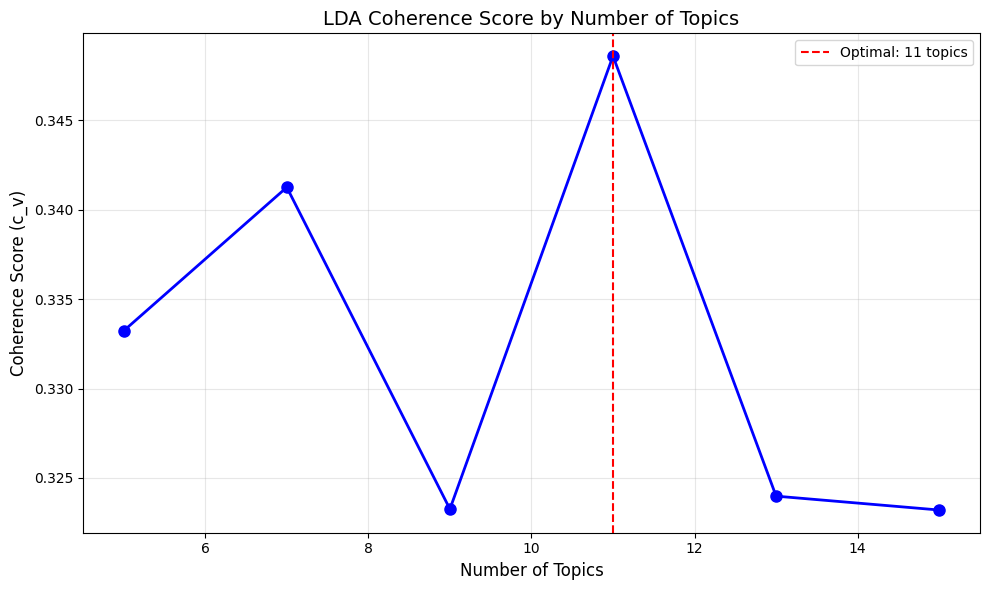

✓ Saved coherence plot


In [64]:
# Visualize LDA coherence
plt.figure(figsize=(10, 6))
topics, scores = zip(*coherence_scores)
plt.plot(topics, scores, 'b-o', linewidth=2, markersize=8)
plt.axvline(x=best_n[0], color='r', linestyle='--', label=f'Optimal: {best_n[0]} topics')
plt.xlabel('Number of Topics', fontsize=12)
plt.ylabel('Coherence Score (c_v)', fontsize=12)
plt.title('LDA Coherence Score by Number of Topics', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/lda_coherence.png', dpi=150)
plt.show()
print("✓ Saved coherence plot")

In [65]:
# Get document-topic distributions
def get_document_topics(lda_model, corpus):
    """Get dominant topic for each document."""
    doc_topics = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc)
        if topic_dist:
            dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
        else:
            dominant_topic = -1
        doc_topics.append(dominant_topic)
    return doc_topics

lda_topics = get_document_topics(lda_model, corpus)
df['lda_topic'] = lda_topics

print("\nLDA Topic Distribution:")
print(df['lda_topic'].value_counts().sort_index())


LDA Topic Distribution:
lda_topic
0     19
1     39
2     94
3     54
4     60
5     23
6     41
7     23
8     38
9    109
Name: count, dtype: int64


## 3.3 BERTopic (Neural Topic Modeling)

In [66]:
# Initialize BERTopic
print("Initializing BERTopic...")

# Use pre-computed SBERT embeddings for speed
bertopic_model = BERTopic(
    embedding_model='all-MiniLM-L6-v2',
    nr_topics=12,  # Reduce to ~12 topics
    min_topic_size=10,
    verbose=True
)

print("\nFitting BERTopic...")
abstracts = df['original_abstract'].tolist()

# Fit with pre-computed embeddings
bertopic_topics, bertopic_probs = bertopic_model.fit_transform(abstracts, embeddings=sbert_embeddings)

print(f"✓ BERTopic fitting complete")
print(f"Number of topics found: {len(set(bertopic_topics)) - 1}")  # -1 excludes outlier topic

Initializing BERTopic...

Fitting BERTopic...


2025-12-02 04:53:52,443 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-02 04:53:53,447 - BERTopic - Dimensionality - Completed ✓
2025-12-02 04:53:53,448 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-02 04:53:53,467 - BERTopic - Cluster - Completed ✓
2025-12-02 04:53:53,468 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-02 04:53:53,556 - BERTopic - Representation - Completed ✓
2025-12-02 04:53:53,557 - BERTopic - Topic reduction - Reducing number of topics
2025-12-02 04:53:53,558 - BERTopic - Topic reduction - Number of topics (12) is equal or higher than the clustered topics(3).
2025-12-02 04:53:53,559 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-02 04:53:53,654 - BERTopic - Representation - Completed ✓


✓ BERTopic fitting complete
Number of topics found: 2


In [67]:
# Display BERTopic topics
print("\nBERTopic Topics:")
topic_info = bertopic_model.get_topic_info()
print(topic_info.head(15))


BERTopic Topics:
   Topic  Count                         Name  \
0     -1      1  -1_visual_the_image_objects   
1      0     63       0_the_sentiment_of_and   
2      1    436              1_the_and_of_to   

                                      Representation  \
0  [visual, the, image, objects, in, features, ne...   
1  [the, sentiment, of, and, analysis, to, in, on...   
2    [the, and, of, to, in, we, for, that, on, with]   

                                 Representative_Docs  
0  [Named Entity Recognition (NER) in social medi...  
1  [With advanced digitalisation, we can observe ...  
2  [Learning and identifying key concepts from pa...  


In [68]:
# Get top words for each topic
print("\nTop words per BERTopic topic:")
for topic_id in range(min(10, len(bertopic_model.get_topics()))):
    if topic_id == -1:
        continue
    topic_words = bertopic_model.get_topic(topic_id)
    if topic_words:
        words = [word for word, _ in topic_words[:8]]
        print(f"  Topic {topic_id}: {', '.join(words)}")


Top words per BERTopic topic:
  Topic 0: the, sentiment, of, and, analysis, to, in, on
  Topic 1: the, and, of, to, in, we, for, that


In [69]:
# Visualize BERTopic
print("\nGenerating BERTopic visualizations...")

# Topic word scores
try:
    fig_barchart = bertopic_model.visualize_barchart(top_n_topics=10)
    fig_barchart.write_html('visualizations/bertopic_barchart.html')
    print("✓ Saved barchart visualization")
except Exception as e:
    print(f"Barchart visualization failed: {e}")

# Topic hierarchy
try:
    fig_hierarchy = bertopic_model.visualize_hierarchy()
    fig_hierarchy.write_html('visualizations/bertopic_hierarchy.html')
    print("✓ Saved hierarchy visualization")
except Exception as e:
    print(f"Hierarchy visualization failed: {e}")

# Intertopic distance map
try:
    fig_topics = bertopic_model.visualize_topics()
    fig_topics.write_html('visualizations/bertopic_topics.html')
    print("✓ Saved topics visualization")
except Exception as e:
    print(f"Topics visualization failed: {e}")


Generating BERTopic visualizations...
✓ Saved barchart visualization
✓ Saved hierarchy visualization
Topics visualization failed: zero-size array to reduction operation maximum which has no identity


In [70]:
# Add BERTopic labels to dataframe
df['bertopic_topic'] = bertopic_topics

print("\nBERTopic Topic Distribution:")
print(df['bertopic_topic'].value_counts().head(15))


BERTopic Topic Distribution:
bertopic_topic
 1    436
 0     63
-1      1
Name: count, dtype: int64



Generating word clouds...


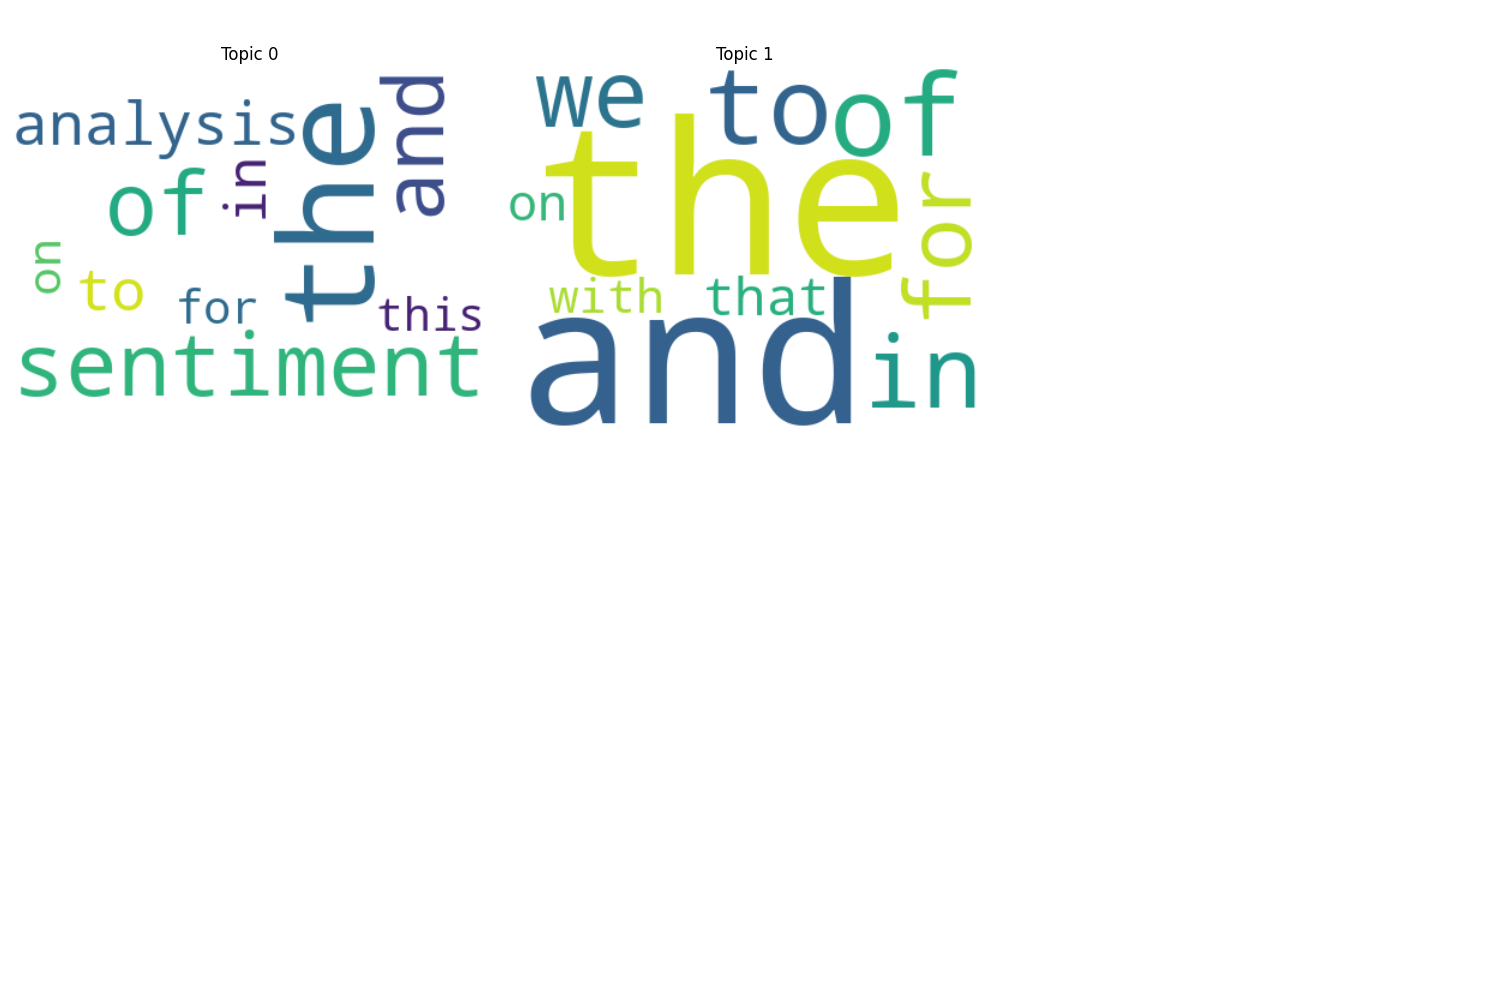

✓ Saved word clouds


In [71]:
# Generate word clouds for top topics
print("\nGenerating word clouds...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(bertopic_model.get_topics()) - 1:  # Skip outlier topic
        ax.axis('off')
        continue

    topic_words = bertopic_model.get_topic(i)
    if topic_words:
        word_freq = {word: abs(score) for word, score in topic_words}
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(word_freq)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {i}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('visualizations/topic_wordclouds.png', dpi=150)
plt.show()
print("✓ Saved word clouds")

In [72]:
# Save topic modeling components
print("\nSaving topic modeling components...")

# Save LDA model
lda_model.save('models/lda_model')
dictionary.save('models/lda_dictionary')
print("✓ Saved LDA model and dictionary")

# Save BERTopic model
bertopic_model.save('models/bertopic_model')
print("✓ Saved BERTopic model")

# Save topic results
topic_results = {
    'kmeans': {
        'n_clusters': n_clusters,
        'top_terms': {str(k): v for k, v in kmeans_terms.items()}
    },
    'lda': {
        'n_topics': n_topics,
        'coherence_score': coherence_score,
        'perplexity': perplexity,
        'optimal_topics': best_n[0],
        'topics': {str(i): lda_model.print_topic(i) for i in range(n_topics)}
    },
    'bertopic': {
        'n_topics': len(set(bertopic_topics)) - 1,
        'topic_info': topic_info.to_dict()
    }
}

with open('data/topic_modeling/topic_results.json', 'w') as f:
    json.dump(topic_results, f, indent=2, default=str)
print("✓ Saved topic modeling results")

# Save updated dataframe with all labels
df.to_parquet('data/processed/papers_with_topics.parquet', index=False)
print("✓ Saved updated dataframe with topic assignments")

2025-12-02 04:53:54,600 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



Saving topic modeling components...
✓ Saved LDA model and dictionary
✓ Saved BERTopic model
✓ Saved topic modeling results
✓ Saved updated dataframe with topic assignments


---
# Final Summary

In [73]:
print("\n" + "="*80)
print("DAY 2 DELIVERABLES - COMPLETE PIPELINE SUMMARY")
print("="*80)

print("\n🔍 PART 1: RETRIEVAL ENGINE")
print(f"  ✓ BM25 keyword search implemented")
print(f"  ✓ FAISS semantic vector search (dimension: {faiss_retriever.dimension})")
print(f"  ✓ Hybrid retrieval (BM25: 30%, Semantic: 70%)")
print(f"  ✓ FAISS ID mapping saved for Day 3 integration")
print(f"  ✓ Evaluation metrics:")
print(f"      - BM25 Recall@5: {bm25_metrics['recall@5']:.4f}")
print(f"      - FAISS Recall@5: {faiss_metrics['recall@5']:.4f}")
print(f"      - Hybrid Recall@5: {hybrid_metrics['recall@5']:.4f}")

print("\n📊 PART 2: CLASSIFICATION (with Model Distillation)")
print(f"  ✓ Label taxonomy: {len(CATEGORIES)} categories")
print(f"  ✓ Teacher model: facebook/bart-large-mnli (Zero-Shot)")
print(f"  ✓ Student model: SBERT + LogReg (fast inference)")
print(f"      - F1 Macro: {classification_metrics['f1_macro']:.4f}")
print(f"      - F1 Weighted: {classification_metrics['f1_weighted']:.4f}")

print("\n🎯 PART 3: TOPIC MODELING")
print(f"  ✓ TF-IDF + K-Means baseline ({n_clusters} clusters)")
print(f"  ✓ LDA topic model")
print(f"      - Topics: {n_topics}")
print(f"      - Coherence (c_v): {coherence_score:.4f}")
print(f"      - Optimal topics: {best_n[0]}")
print(f"  ✓ BERTopic (UMAP + HDBSCAN + c-TF-IDF)")
print(f"      - Topics found: {len(set(bertopic_topics)) - 1}")
print(f"  ✓ Visualizations generated")

print("\n📁 OUTPUT FILES")
output_files = [
    'data/retrieval/faiss_index.bin',
    'data/retrieval/faiss_id_mapping.pkl',
    'data/retrieval/bm25_retriever.pkl',
    'data/retrieval/evaluation_results.json',
    'data/classification/taxonomy.json',
    'data/classification/metrics.json',
    'models/embedding_classifier.pkl',
    'models/lda_model',
    'models/bertopic_model',
    'data/topic_modeling/topic_results.json',
    'data/processed/papers_with_topics.parquet',
    'visualizations/category_distribution.png',
    'visualizations/classification_confusion_matrix.png',
    'visualizations/lda_coherence.png',
    'visualizations/topic_wordclouds.png'
]

total_size = 0
for filepath in output_files:
    if os.path.exists(filepath):
        try:
            size_mb = os.path.getsize(filepath) / (1024 * 1024)
            total_size += size_mb
            print(f"  ✓ {filepath} ({size_mb:.2f} MB)")
        except:
            print(f"  ✓ {filepath} (directory)")
    else:
        print(f"  ⏳ {filepath}")

print(f"\n  Total storage: {total_size:.2f} MB")

print("\n" + "="*80)
print("✅ DAY 2 DELIVERABLES COMPLETE!")
print("="*80)

print("\n📋 Files to download for Day 3:")
print("   - data/processed/")
print("   - data/retrieval/")
print("   - data/classification/")
print("   - data/topic_modeling/")
print("   - data/embeddings/")
print("   - models/")

print("\n📊 Day 3 Tasks:")
print("  1. Summarization Engine (TextRank + BART/PEGASUS)")
print("  2. Explainability (LIME + SHAP)")
print("  3. Streamlit/Gradio UI")
print("  4. End-to-end pipeline (run_pipeline.py)")
print("  5. Final digest JSON output")

print("\n⚠️  Remember to copy these class definitions to Day 3 app.py:")
print("   - BM25Retriever")
print("   - FAISSRetriever")
print("   - HybridRetriever")
print("   - EmbeddingClassifier")

print("\n" + "="*80)


DAY 2 DELIVERABLES - COMPLETE PIPELINE SUMMARY

🔍 PART 1: RETRIEVAL ENGINE
  ✓ BM25 keyword search implemented
  ✓ FAISS semantic vector search (dimension: 384)
  ✓ Hybrid retrieval (BM25: 30%, Semantic: 70%)
  ✓ FAISS ID mapping saved for Day 3 integration
  ✓ Evaluation metrics:
      - BM25 Recall@5: 0.1733
      - FAISS Recall@5: 0.1289
      - Hybrid Recall@5: 0.1567

📊 PART 2: CLASSIFICATION (with Model Distillation)
  ✓ Label taxonomy: 12 categories
  ✓ Teacher model: facebook/bart-large-mnli (Zero-Shot)
  ✓ Student model: SBERT + LogReg (fast inference)
      - F1 Macro: 0.1519
      - F1 Weighted: 0.5055

🎯 PART 3: TOPIC MODELING
  ✓ TF-IDF + K-Means baseline (10 clusters)
  ✓ LDA topic model
      - Topics: 10
      - Coherence (c_v): 0.3473
      - Optimal topics: 11
  ✓ BERTopic (UMAP + HDBSCAN + c-TF-IDF)
      - Topics found: 2
  ✓ Visualizations generated

📁 OUTPUT FILES
  ✓ data/retrieval/faiss_index.bin (0.73 MB)
  ✓ data/retrieval/faiss_id_mapping.pkl (0.02 MB)
  ✓ d